In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import clear_output
from torch.utils.data import DataLoader

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class P:
    device='cuda:4'
    env='CartPole-v1'
    num_envs=16
    hidden_units=128
    lr=3e-4
    num_steps_td=5
    max_steps=6000
    gamma=0.99
    tau=0.95
    eval_every=500
    n_eval_episodes=10
    lambda_policy = 1
    lambda_value = 0.5
    lambda_entropy = 0.001
    ppo_epochs = 4
    ppo_batch_size = 5
    clip_epsilon = 0.2

# Envs

In [3]:
envs = gym.vector.make(P.env, num_envs=P.num_envs)
test_env = gym.make(P.env)

# Neural Network

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(ActorCritic, self).__init__()

        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist = Categorical(probs)
        return dist, value

In [5]:
num_inputs = envs.single_observation_space.shape[0]
num_outputs = envs.single_action_space.n
num_inputs, num_outputs

(4, 2)

In [6]:
model = ActorCritic(num_inputs, num_outputs, P.hidden_units).to(P.device)
optimizer = optim.Adam(model.parameters(), lr=P.lr)

# Helper funcs

In [7]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.title("frame %s. reward: %s" % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [8]:
def evaluate(env, model, device):
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, termination, truncation, info = env.step(dist.sample().cpu().numpy()[0])
        done = termination or truncation
        state = next_state
        total_reward += reward
    return total_reward

# GAE

In [9]:
def compute_gae(next_value, rewards, masks, values, gamma, tau):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

# A2C

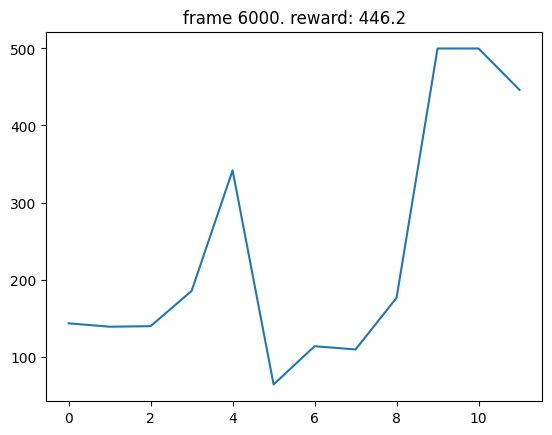

500.0

In [10]:
frame_idx = 0
test_rewards = []

state, _ = envs.reset()
while frame_idx < P.max_steps:
    log_probs = []
    values = []
    states = []  # new
    actions = []  # new
    rewards = []
    masks = []
    entropy = 0

    for _ in range(P.num_steps_td):
        state = torch.FloatTensor(state)
        state = state.to(P.device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        done = np.logical_or(terminations, truncations)

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(P.device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(P.device))
        states.append(state)  # new
        actions.append(action)  # new

        state = next_state
        frame_idx += 1
        if frame_idx % P.eval_every == 0:
            test_rewards.append(np.mean([evaluate(test_env, model, P.device) for _ in range(P.n_eval_episodes)]))
            plot(frame_idx, test_rewards)

    # Bootstrap to get returns in n-step
    next_state = torch.FloatTensor(state).to(P.device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values, P.gamma, P.tau)

    log_probs = torch.cat(log_probs).detach()  # new
    returns = torch.cat(returns).detach()
    values = torch.cat(values).detach()  # new
    states = torch.cat(states)
    actions = torch.cat(actions)
    advantages = returns - values

    # Losses
    # actor_loss = -(log_probs * advantage.detach()).mean()
    # critic_loss = advantage.pow(2).mean()

    # PPO learning update
    for _ in range(P.ppo_epochs):
        dataset = list(zip(states, actions, log_probs, returns, advantages))
        dataloader = DataLoader(dataset, batch_size=P.ppo_batch_size, shuffle=True)
        for state_, action, old_log_probs, return_, advantage in dataloader:
            dist, value = model(state_)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            # Why (log_prob, minus, exp) instead of (prob, div)?
            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - P.clip_epsilon, 1.0 + P.clip_epsilon) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = (
                (P.lambda_policy * actor_loss)
                + (P.lambda_value * critic_loss)
                - (P.lambda_entropy * entropy)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

evaluate(test_env, model, P.device)